# Data Analysis and Mining - PCA

## Objectives 
- Perform Principal Component Analysis.
- Perform Single Value Decomposition.

## Initialization

### Import libraries

In [683]:
import numpy as np
import pandas as pd
import seaborn as sns
import skfuzzy as fuzz

from matplotlib import pyplot as plt

%matplotlib inline
sns.set_style("darkgrid")

### Load data

Start by loading the entire dataset.

In [684]:
# Specify the path to the dataset CSV file
dataset_path = "../../Dataset/dataset.csv"

# Read the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path)

df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Wisconsin,B10,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,...,22.4,54.8,44.7,36.5,37.5,59.3,11.3,2ND,1.0,2015
2,Michigan,B10,40,33,114.4,90.4,0.9375,53.9,47.7,14.0,...,30.0,54.7,46.8,35.2,33.2,65.9,6.9,2ND,3.0,2018
3,Texas Tech,B12,38,31,115.2,85.2,0.9696,53.5,43.0,17.7,...,36.6,52.8,41.9,36.5,29.7,67.5,7.0,2ND,3.0,2019
4,Gonzaga,WCC,39,37,117.8,86.3,0.9728,56.6,41.1,16.2,...,26.9,56.3,40.0,38.2,29.0,71.5,7.7,2ND,1.0,2017


### Data cleaning

Then, we drop columns that we do not need. In addition, we add one more column which represents the percentage of win games, as it is one of the most interesting features.

In [685]:
# Drop columns 'TEAM', 'CONF', 'POSTSEASON', 'SEED'
df = df.drop(['TEAM', 'CONF', 'POSTSEASON', 'SEED'], axis=1)

Check the size of the dataset.

In [686]:
df.shape

(1757, 20)

We decided to analyze a subset of the whole dataset. Since our dataset is a collection of data which belongs to 5 different seasons, we filter the dataset by only keeping and analyzing the information related to one year.

In [687]:
# Filter by year, keep only data from selected year
df = df[df['YEAR'] == 2015].drop('YEAR', axis=1)

Check the size of the dataset.

In [688]:
df.shape

(351, 19)

In [689]:
# Reset the index
df = df.reset_index(drop=True)

df.head()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
0,40,36,129.1,93.6,0.9758,54.8,47.7,12.4,15.8,32.1,23.7,36.2,22.4,54.8,44.7,36.5,37.5,59.3,11.3
1,39,35,125.2,90.6,0.9764,56.6,46.5,16.3,18.6,35.8,30.2,39.8,23.9,55.9,46.3,38.7,31.4,66.4,10.7
2,36,27,109.4,87.4,0.9290,47.7,44.0,17.2,21.3,34.7,30.8,38.7,33.3,48.4,43.3,30.7,30.3,65.6,5.8
3,38,32,125.3,98.6,0.9401,58.3,47.9,14.5,17.3,27.9,32.2,36.7,24.1,58.2,47.4,39.0,32.6,63.9,8.6
4,38,34,117.5,86.9,0.9700,53.5,45.1,16.5,20.6,34.5,22.4,47.1,37.3,53.3,42.7,36.0,33.5,66.7,9.0


### Classification

Set up a list of colours.

In [690]:
colours = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

And let's center it now.

In [691]:
# To do PCA, normalize data getting df1 by standard deviation and df2 by min-max
df = (df - df.mean()) / df.std()

## Fuzzy clustering

### Visualization

Preprocess...

In [692]:
# Get data as numpy array
alldata = df.values

# Set parameters
num_seeds = 10
num_clusters = 5

# Prepare colors
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Store info in a dictionary which maps to ncenters and seed the matrix of centers m, the list cluster_centers and the last value of jm
info = {}
# And a dictionary which maps to each value of c the best
best = {}

for ncenters in range(2, num_clusters+1):

    for seed in range(num_seeds):

        # Compute fuzzy c-means clustering
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(alldata.T, ncenters, 2, error=0.005, maxiter=1000, init=None, seed=seed)

        # Assign cluster centers
        cluster_centers = np.argmax(u, axis=0)

        # Init a matrix with 2 rows and df.columns columns to compute the centroid of each cluster (cntr are wrong)
        m = np.zeros((ncenters, df.shape[1]))

        # Compute centers (cntr are wrong)
        for j in range(ncenters):
            # For each column in the dataset, store the mean for the cluster_centers == j elements (cntr are wrong)
            for i in range(df.shape[1]):
                m[j, i] = df.iloc[cluster_centers == j, i].mean()

        # Store info
        info[ncenters, seed] = (m, cluster_centers, jm[-1], u)

    # Only select from info the info related to the seed with minimum jm
    best[ncenters] = info[ncenters, np.argmin([info[ncenters, seed][2] for seed in range(num_seeds)])]


Visualize over ADJOE and ADJDE.

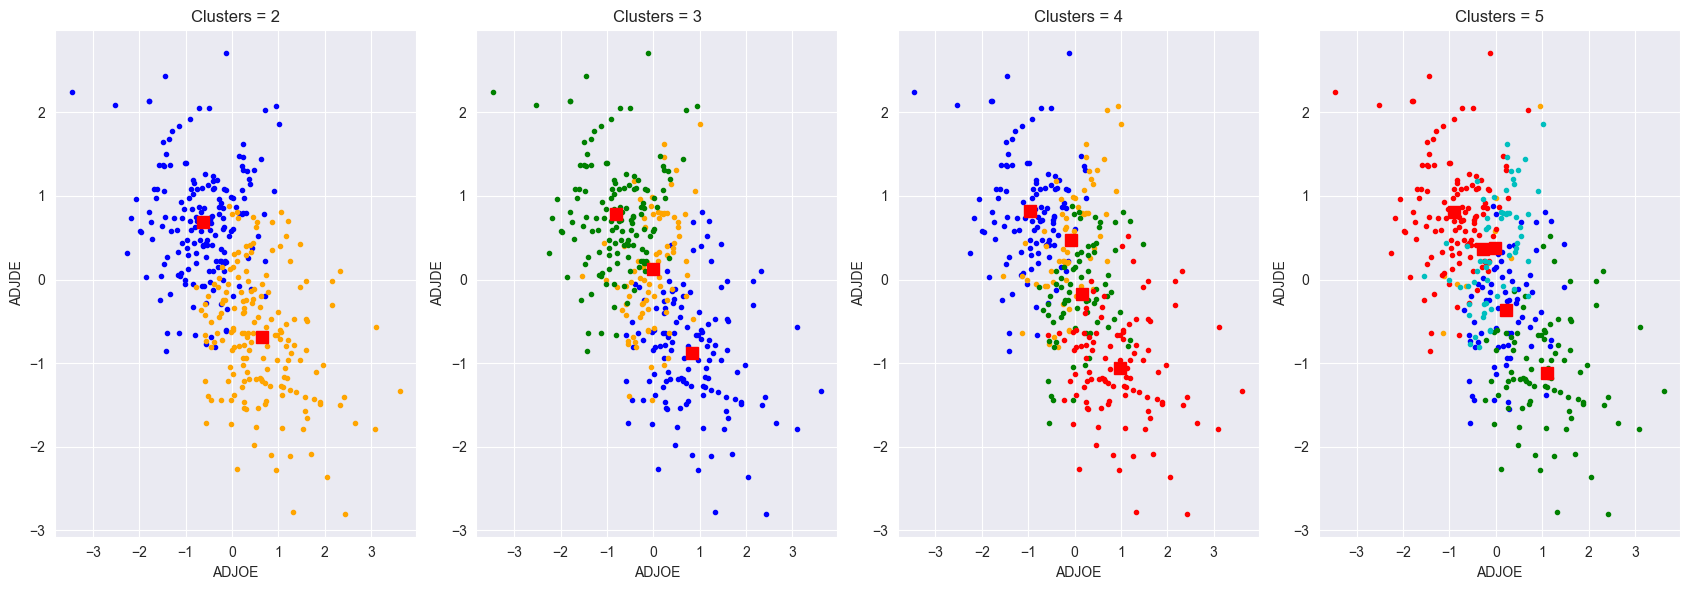

In [693]:
# One plot for each number of clusters
fig1, axes1 = plt.subplots(1, num_clusters-1, figsize=(17, 6))

for ncenters, ax in enumerate(axes1.reshape(-1), 2):

    # Plot data
    for j in range(ncenters):
        # Plot over PC1 and PC2 data such that their cluster_center == j
        ax.plot(df['ADJOE'][best[ncenters][1] == j], df['ADJDE'][best[ncenters][1] == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in best[ncenters][0]:
        ax.plot(pt[2], pt[3], 'rs', markersize=8)

    # Add title to the plot
    ax.set_title('Clusters = {0}'.format(ncenters))
    # Add labels to the plot
    ax.set_xlabel('ADJOE')
    ax.set_ylabel('ADJDE')

fig1.tight_layout()

Project data to better features using PCA for visualization...

In [694]:
# Compute the covariance matrix from df
covmatrix = df.cov()

# Obtain the eigenvalues and eigenvectors from the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(covmatrix)

# Sort the eigenvalues in descending order
idxs = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idxs]
eigenvectors = eigenvectors[:,idxs]

# Obtain principal components (data in the new space)
pc = np.dot(df, eigenvectors)

# Make pc a dataframe
names = ["PC"+str(x+1) for x in range(pc.shape[1])]
df_pc = pd.DataFrame(data = pc, columns = names)

Visualize over PC1 and PC2.

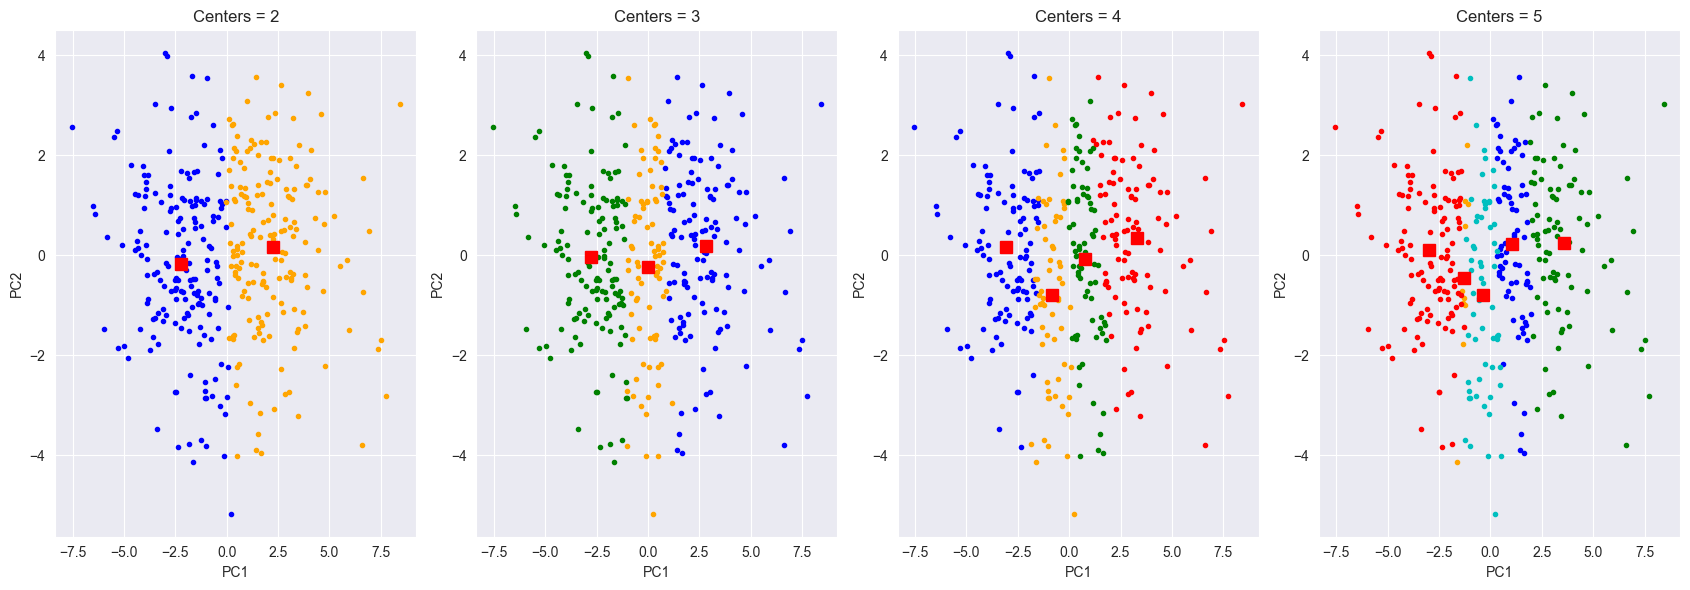

In [695]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(1, num_clusters-1, figsize=(17, 6))

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    
    # Plot data
    for j in range(ncenters):
        # Plot over PC1 and PC2 data such that their cluster_center == j
        ax.plot(df_pc['PC1'][best[ncenters][1] == j], df_pc['PC2'][best[ncenters][1] == j], '.', color=colors[j])

    # Compute the centers in the new space
    m = np.dot(best[ncenters][0], eigenvectors)
    # Mark the center of each fuzzy cluster
    for pt in m:
        ax.plot(pt[0], pt[1], 'rs', markersize=8)

    # Add title to the plot
    ax.set_title('Centers = {0}'.format(ncenters))
    # Add labels to the plot
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

fig1.tight_layout()


### Choose the best number of clusters

As the plot below shows, it's pointless to pick the number of clusters which minimizes the cost function.

Text(0, 0.5, 'Cost Function')

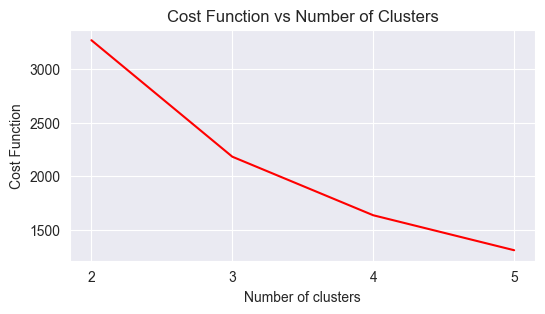

In [696]:
# Plot the best cost function obtained for each ncenters
plt.figure(figsize=(6, 3))

# Add a line to connect the points
plt.plot(range(2, num_clusters+1), [best[ncenters][2] for ncenters in range(2, num_clusters+1)], 'r-')

# Only show integers in the x-axis
plt.xticks(range(2, num_clusters+1))

plt.title('Cost Function vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Cost Function')

Thus, let's see if any number of clusters is stable.

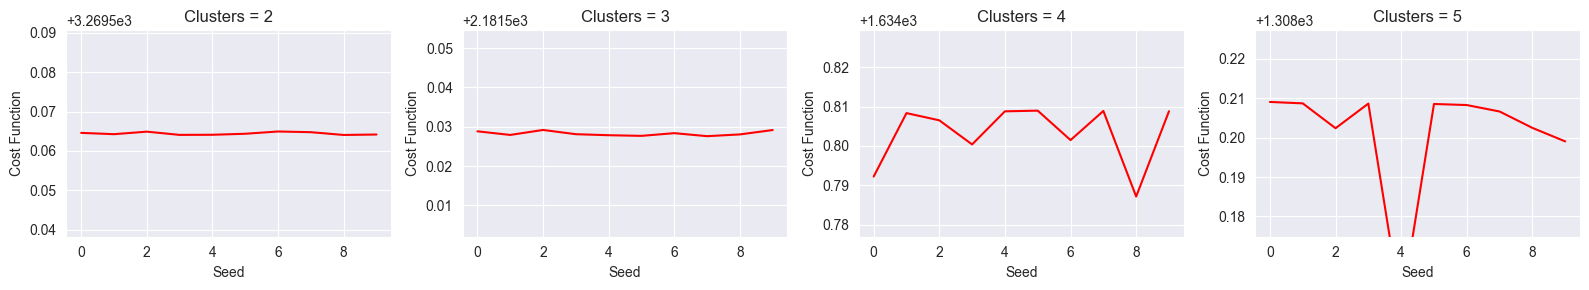

In [697]:
# Make one plot for each value of ncenters
fig1, axes1 = plt.subplots(1, num_clusters-1, figsize=(16, 3))

# Compute avg cost function for each cluster
avg = {}

# Compute max difference between the max and min cost function values for each cluster
diff = 0

# Plot the cost function for each seed
for ncenters in range(2, num_clusters+1):

    # Plot the line
    axes1[ncenters-2].plot(range(num_seeds), [info[ncenters, seed][2] for seed in range(num_seeds)], 'r-')
    # Add title to the plot
    axes1[ncenters-2].set_title('Clusters = {0}'.format(ncenters))
    # Add labels to the plot
    axes1[ncenters-2].set_xlabel('Seed')
    axes1[ncenters-2].set_ylabel('Cost Function')

    # Compute the max difference between the cost function values for each cluster, and the average cost function for each
    min = np.inf
    max = -np.inf
    avg[ncenters] = 0
    for seed in range(num_seeds):
        avg[ncenters] += info[ncenters, seed][2]
        if info[ncenters, seed][2] > max:
            max = info[ncenters, seed][2]
        if info[ncenters, seed][2] < min:
            min = info[ncenters, seed][2]
    avg[ncenters] /= num_seeds
    if diff < max - min:
        diff = max - min

for ncenters in range(2, num_clusters+1):
    axes1[ncenters-2].set_ylim(avg[ncenters]-diff/2, avg[ncenters]+diff/2)

fig1.tight_layout()


Let's plot the membership values for each cluster...

Text(0.5, 1.0, 'Good team')

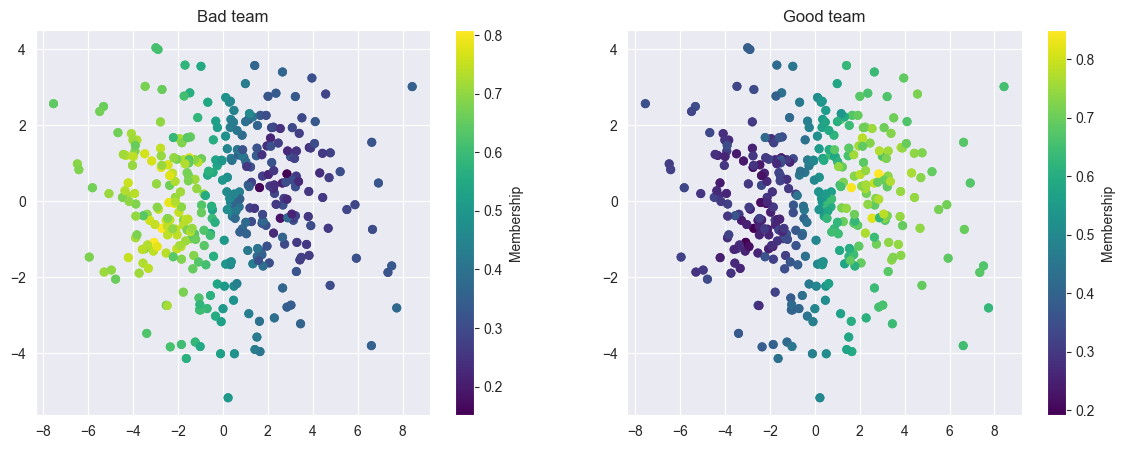

In [698]:
# Assuming the best number of clusters is 2
n = 2

fig, axes = plt.subplots(1, n, figsize=(14, 5))
for cluster_num, ax in enumerate(axes.reshape(-1)):
    ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30)
    # Add colorbar
    cbar = plt.colorbar(ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30), ax=ax)
    cbar.set_label('Membership')
    ax.grid(True)

# Add titles to the first and second subplots
axes[0].set_title('Bad team')
axes[1].set_title('Good team')

Text(0.5, 1.0, 'Good team')

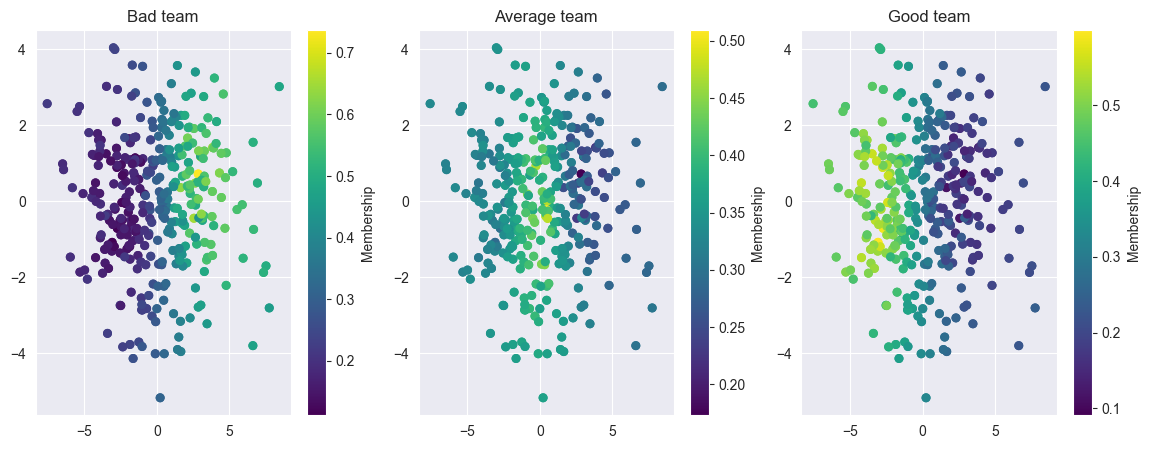

In [699]:
# Assuming the best number of clusters is 3
n = 3

fig, axes = plt.subplots(1, n, figsize=(14, 5))
for cluster_num, ax in enumerate(axes.reshape(-1)):
    ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30)
    # Add colorbar
    cbar = plt.colorbar(ax.scatter(df_pc['PC1'], df_pc['PC2'], c=best[n][3][cluster_num], cmap='viridis', s=30), ax=ax)
    cbar.set_label('Membership')
    ax.grid(True)

# Add titles to the first and second subplots
axes[0].set_title('Bad team')
axes[1].set_title('Average team')
axes[2].set_title('Good team')

## (Iterative) Anomalous Pattern Clustering

